# Nowcasting 3D U-Net

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [24]:
import pyearthtools.data as petdata
import pyearthtools.pipeline as petpipe
from pyearthtools.data import Petdt
from pyearthtools.data.time import TimeResolution
from pyearthtools.pipeline.operation import Operation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Autodetect GPU and use if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading data and choosing variables

To load and prepare the data, we will use the PyEarthTools site accessor, and then build a pipeline with the data accessor to do the necessary transforms to prepare the data for training an autoencoder.

In [14]:
# this needs to be loaded in order to have access the dataset

import site_archive_jasmin as saj                  
print(saj.ROOT_DIRECTORIES)

{'ERA5lowres': '/gws/ssde/j25a/mmh_storage/theme3/weatherbench/5.625deg/', 'MOGLOBAL': '/gws/ssde/j25a/mmh_storage/theme3/mo_pet_site_archive/mo_global/', 'MOUKV': '/gws/ssde/j25a/mmh_storage/theme3/mo_pet_site_archive/mo_ukv/', 'Himawari': '/gws/ssde/j25a/mmh_storage/theme3/rv74_himawari', 'HimawariChannels': '/gws/ssde/j25a/mmh_storage/theme3/ra22_himawari', 'Rainfields3': '/gws/ssde/j25a/mmh_storage/theme3/rq0_rainfields_prcp_crate'}


In [15]:
# Define Himawari accessor
vars_to_load = ["surface_global_irradiance", "cloud_optical_depth"]
himawari = petdata.archive.Himawari(vars_to_load)

# Checking the loaded dataset

We can see the temporal resolution, the coords and the variables (channels)

In [16]:
himawari

Himawari
	Description                    Himawari 8/9 satellite data
		 Range                          '2019-current'
		 Resolution                     '10 minutes'


	Initialisation                 
		 data_interval                  (10, 'm')
		 file_regex                     '*{date_info}*{time_info}*.nc'
		 variables                      ['surface_global_irradiance', 'cloud_optical_depth']
	Transforms                     
		 StandardCoordinateNames        {'latitude': "['lat', 'Latitude', 'yt_ocean', 'yt']", 'longitude': "['lon', 'Longitude', 'xt_ocean', 'xt']", 'replacement_dictionary': 'None', 'time': "['Time']"}
		 Trim                           {'__args': '()', 'variables': "['surface_global_irradiance', 'cloud_optical_depth']"}

In [9]:
ds = himawari["20210607T1930"]
ds

<xarray.Dataset> Size: 61MB
Dimensions:                    (time: 1, latitude: 1726, longitude: 2214)
Coordinates:
  * time                       (time) datetime64[ns] 8B 2021-06-07T19:30:00
  * latitude                   (latitude) float32 7kB -44.5 -44.48 ... -10.0
  * longitude                  (longitude) float32 9kB 112.0 112.0 ... 156.3
Data variables:
    surface_global_irradiance  (time, latitude, longitude) float64 31MB dask.array<chunksize=(1, 1726, 2214), meta=np.ndarray>
    cloud_optical_depth        (time, latitude, longitude) float64 31MB dask.array<chunksize=(1, 1726, 2214), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                      CF-1.7
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    acknowledgment:                   The following acknowledgement is requir...
    cdm_data_type:                    grid
    comment:                          Solar radiation data derived from satel...
    contributor_name:                 Mines ParisTech; Commonwealth of Austra...
    ...                               ...
    quality:                          0
    quality_meaning:                  0: no_known_issues 1: known_issue 
    project:                          Gridded Solar Observations
    history:                          Mon Mar  4 01:55:54 2024: ncatted -a re...
    references:                       Poulsen C., Majewski L. J. (2022) Gridd...
    NCO:                              netCDF Operators version 4.7.7 (Homepag...

# Create a PET Pipeline to prepare dataset for training

## This function is to make sure to use new index for merging

In [26]:
def proper_temporal_merge(samples):
    valid = []
    for i, s in enumerate(samples):
        if s is not None:
            s = s.copy(deep=True)
            s = s.assign_coords(time=[s.time.values[0] + np.timedelta64(i*10, "m")])
            valid.append(s)
    return xr.concat(valid, dim="time", combine_attrs="override")

## Per-Channel Scaling

In [27]:
class PerChannelScale(Operation):
    def __init__(self, scale_dict):
        """
        scale_dict: dict mapping variable name → scaling factor
        e.g. {"surface_global_irradiance": 1200, "cloud_optical_depth": 60}
        """
        super().__init__(operation="apply")
        self.scale_dict = scale_dict

    def apply_func(self, sample):
        # If TemporalRetrieval returns a tuple, process each element recursively
        if isinstance(sample, tuple):
            return tuple(self.apply_func(s) for s in sample)

        # Normal case: single xarray.Dataset
        ds = sample.copy()
        for var, factor in self.scale_dict.items():
            if var in ds:
                ds[var] = ds[var] / float(factor)
        return ds

# Training data pipeline

In [28]:
scales = {
    "surface_global_irradiance": 1200,   # W/m²
    "cloud_optical_depth": 60            # unitless
}

In [51]:
himawari.data_resolution = TimeResolution("minute")
himawari.data_resolution.value = 10

satpipe = petpipe.Pipeline(
    himawari,
    petpipe.operations.xarray.Sort(order=["time", "latitude", "longitude"]),
    petpipe.operations.xarray.AlignDataVariableDimensionsToDatasetCoords(),

    petpipe.modifications.TemporalRetrieval(
        concat=True,
        samples=((0, 7, 10), (60, 3, 60)),
        merge_function=proper_temporal_merge,
        delta_unit="minute"
    ),

    # --- New bounding box: Darwin region ---
    petdata.transform.region.Bounding(-15.5, -8, 130, 135.5),

    PerChannelScale(scales),  # scale both variables

    petpipe.operations.xarray.conversion.ToNumpy(),
    petpipe.operations.numpy.reshape.Rearrange("t c h w -> c t h w"),

    iterator=petpipe.iterators.DateRange(
        "20210607T0030", "20210610T2300", interval="10 minutes"
    ),
    
    exceptions_to_ignore=(petdata.exceptions.DataNotFoundError, ValueError)
)

# Choosing a sample from the pipeline and plotting them for visual check

In [52]:
t = Petdt(datetime.datetime(2021, 6, 8, 1, 0))
sample = satpipe[t]
inputs, outputs = sample
outputs[1].shape

(2, 276, 276)

In [54]:
inputs.shape

(7, 2, 276, 276)


Input sequence (7 timesteps, 2 variables):
  t−7: μ0=0.017, μ1=0.512 | σ0=0.120, σ1=0.080
  t−6: μ0=0.016, μ1=0.528 | σ0=0.110, σ1=0.081
  t−5: μ0=0.016, μ1=0.542 | σ0=0.106, σ1=0.084
  t−4: μ0=0.017, μ1=0.554 | σ0=0.110, σ1=0.088
  t−3: μ0=0.018, μ1=0.565 | σ0=0.107, σ1=0.093
  t−2: μ0=0.019, μ1=0.575 | σ0=0.100, σ1=0.096
  t−1: μ0=0.020, μ1=0.583 | σ0=0.099, σ1=0.099

Output sequence (3 timesteps, 2 variables):
  t1: μ0=0.021, μ1=0.618 | σ0=0.085, σ1=0.113
  t2: μ0=0.027, μ1=0.566 | σ0=0.083, σ1=0.118
  t3: μ0=0.024, μ1=0.497 | σ0=0.083, σ1=0.102

Input sequence (7 timesteps, 2 variables):


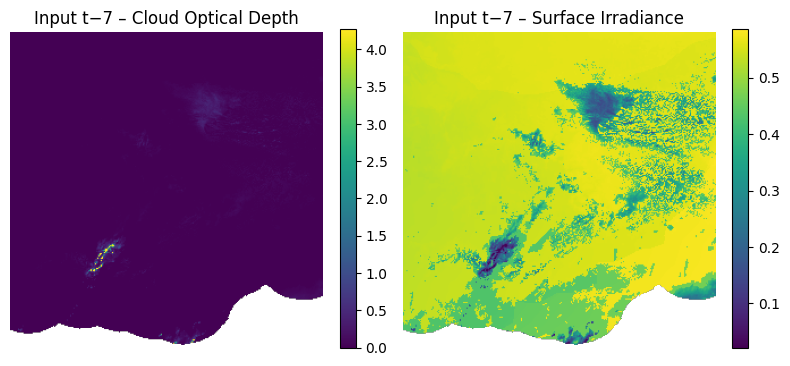

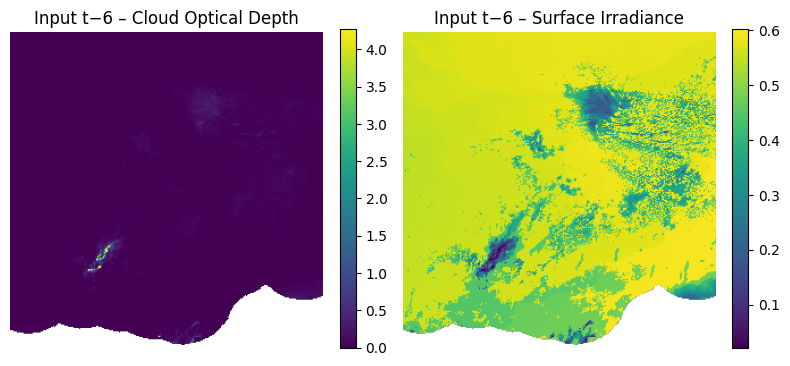

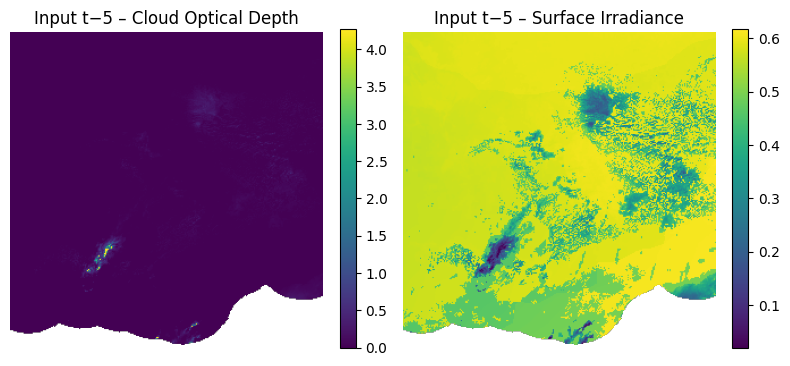

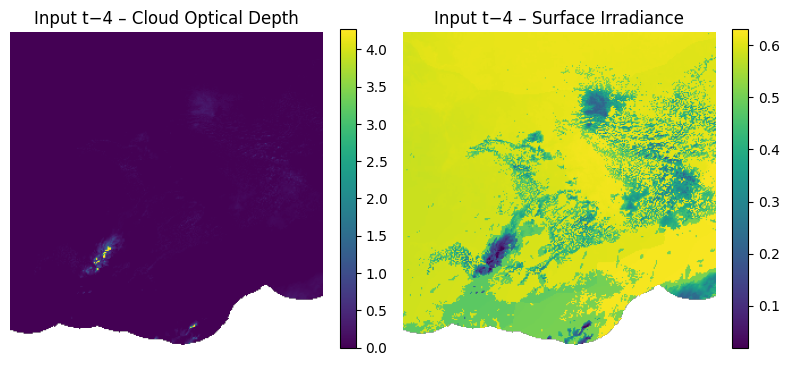

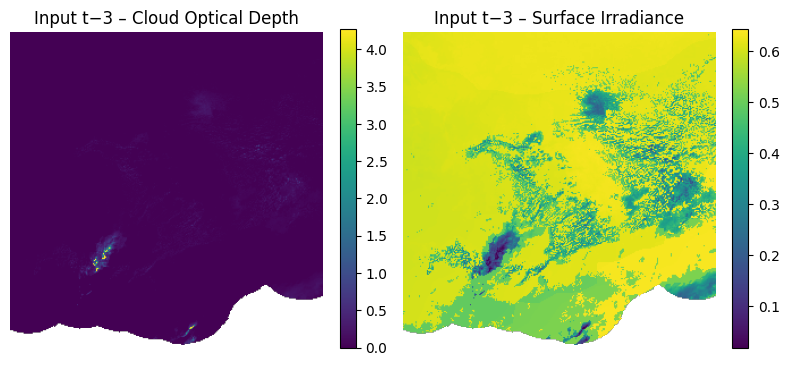

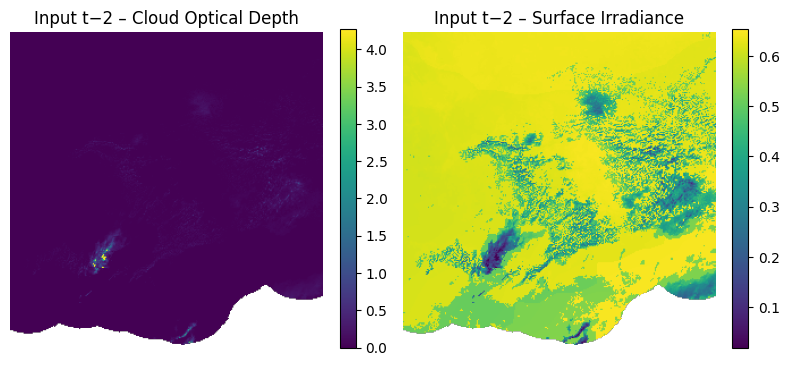

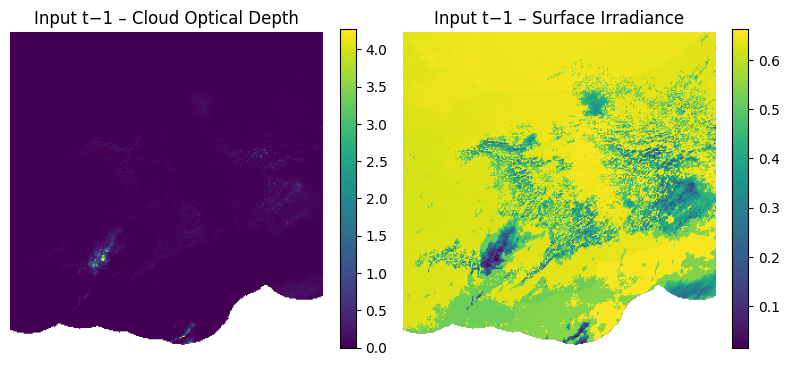


Output sequence (3 timesteps, 2 variables):


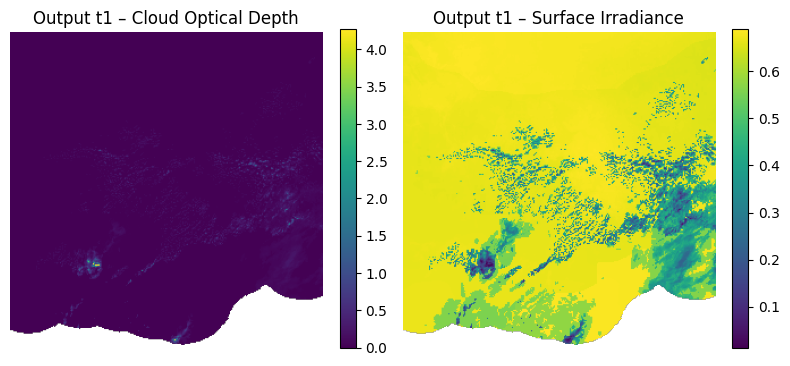

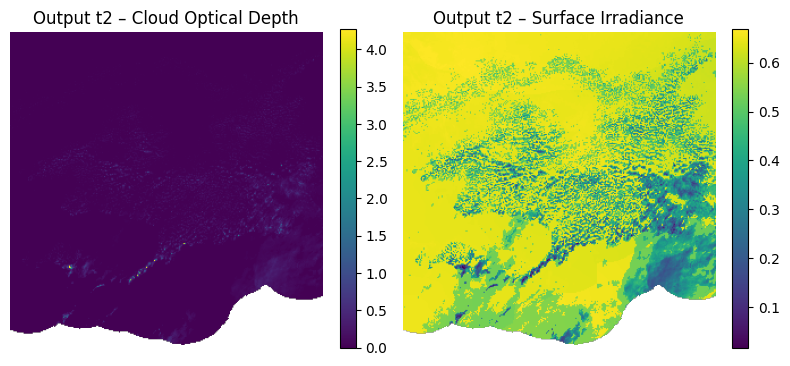

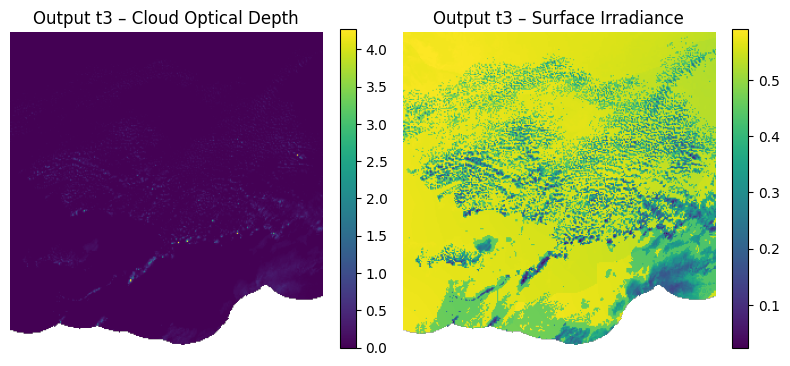

In [43]:
inputs, outputs = sample

def plot_sequence(seq, name, var_names=None, cmap="viridis", t_labels=None):
    n, c, h, w = seq.shape
    var_names = var_names or [f"Var{i}" for i in range(c)]
    if t_labels is None:
        t_labels = [f"t{i}" for i in range(n)]
    print(f"\n{name} sequence ({n} timesteps, {c} variables):")

    for t in range(n):
        fig, axes = plt.subplots(1, c, figsize=(4 * c, 4))
        if c == 1:
            axes = [axes]
        for ch in range(c):
            img = np.where(np.isfinite(seq[t, ch]), seq[t, ch], np.nan)
            ax = axes[ch]
            im = ax.imshow(img, cmap=cmap)
            fig.colorbar(im, ax=ax, fraction=0.046)
            ax.set_title(f"{name} {t_labels[t]} – {var_names[ch]}")
            ax.axis("off")
        plt.tight_layout()
        plt.show()


def describe_sequence(seq, name, t_labels=None):
    n, c, h, w = seq.shape
    if t_labels is None:
        t_labels = [f"t{i}" for i in range(n)]
    print(f"\n{name} sequence ({n} timesteps, {c} variables):")
    for t in range(n):
        means = [float(np.nanmean(seq[t, ch])) for ch in range(c)]
        stds = [float(np.nanstd(seq[t, ch])) for ch in range(c)]
        mean_str = ", ".join([f"μ{ch}={m:.3f}" for ch, m in enumerate(means)])
        std_str = ", ".join([f"σ{ch}={s:.3f}" for ch, s in enumerate(stds)])
        print(f"  {t_labels[t]}: {mean_str} | {std_str}")


# --- Define custom timestep labels ---
t_labels_input = [f"t−{i}" for i in range(7, 0, -1)] + ["t0"]  # t−7 … t0
t_labels_output = [f"t{i}" for i in range(1, 4)]               # t1 … t3

# --- Describe and visualise ---
describe_sequence(inputs, "Input", t_labels=t_labels_input)
describe_sequence(outputs, "Output", t_labels=t_labels_output)

plot_sequence(inputs, "Input",
              var_names=["Cloud Optical Depth", "Surface Irradiance"],
              t_labels=t_labels_input)

plot_sequence(outputs, "Output",
              var_names=["Cloud Optical Depth", "Surface Irradiance"],
              t_labels=t_labels_output)

# Define model

In [44]:
class UNet3D_MixedNowcast(nn.Module):
    def __init__(self, in_channels=2, out_channels=2, base_filters=32, use_lag=False):
        super().__init__()
        self.use_lag = use_lag

        # ---- Encoder ----
        self.enc1 = self._block(in_channels + (1 if use_lag else 0), base_filters)
        self.enc2 = self._block(base_filters, base_filters * 2)
        self.enc3 = self._block(base_filters * 2, base_filters * 4)
        self.pool = nn.MaxPool3d((1, 2, 2))  # halve spatial dims only

        # ---- Bottleneck ----
        self.bottleneck = self._block(base_filters * 4, base_filters * 8)

        # ---- Decoder ----
        self.up3 = nn.ConvTranspose3d(base_filters * 8, base_filters * 4,
                                      kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec3 = self._block(base_filters * 8, base_filters * 4)
        self.up2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2,
                                      kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec2 = self._block(base_filters * 4, base_filters * 2)
        self.up1 = nn.ConvTranspose3d(base_filters * 2, base_filters,
                                      kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.dec1 = self._block(base_filters * 2, base_filters)

        # ---- Temporal projection ----
        self.temporal_head = nn.Sequential(
            nn.Conv3d(base_filters, base_filters, (3, 1, 1), padding=(1, 0, 0)),
            nn.ReLU(inplace=True),
            nn.Conv3d(base_filters, out_channels, (3, 1, 1), padding=(1, 0, 0))
        )

    def _block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv3d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, lag=None):
        # Input: (B, 2, T, 276, 276)
        if self.use_lag and lag is not None:
            x = torch.cat([x, lag], dim=1)

        # --- Downscale to power-of-two size ---
        x256 = F.interpolate(x, size=(x.shape[2], 256, 256),
                             mode="trilinear", align_corners=False)

        # ---- Encoder ----
        e1 = self.enc1(x256)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b  = self.bottleneck(self.pool(e3))

        # ---- Decoder ----
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        # ---- Temporal head ----
        out256 = self.temporal_head(d1)        # (B, 2, T, 256, 256)
        out256 = out256[:, :, -3:, :, :]       # keep last 3 future frames

        # --- Upscale back to original 276×276 ---
        out = F.interpolate(out256, size=(out256.shape[2], 276, 276),
                            mode="trilinear", align_corners=False)

        return out

In [45]:
model = UNet3D_MixedNowcast(
    in_channels=2,
    out_channels=2,
    base_filters=32,
    use_lag=False
)

# --- Test run ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [30]:
#model

# Define loss function

In [60]:
class PooledMSELoss(nn.Module):
    def __init__(self, pool=9):
        super().__init__()
        self.pool = pool

    def forward(self, pred, target):
        # pred, target: (B, C, T, H, W)
        B, C, T, H, W = pred.shape

        # depthwise kernel (one per channel)
        kernel = torch.ones((C, 1, 1, self.pool, self.pool), device=pred.device) / (self.pool ** 2)

        # smooth each channel independently
        pred_smooth = F.conv3d(
            pred, kernel, padding=(0, self.pool // 2, self.pool // 2), groups=C
        )
        target_smooth = F.conv3d(
            target, kernel, padding=(0, self.pool // 2, self.pool // 2), groups=C
        )

        return F.mse_loss(pred_smooth, target_smooth)


In [61]:
criterion = PooledMSELoss(pool=9)

In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training

In [63]:
def train(debug=True, num_epochs=1, max_samples=10, print_per=20):
    """
    Main training loop for the nowcasting model using pooled MSE loss.
    """
    sample_ix = 0 

    for epoch in range(num_epochs):
        total_loss = 0.0    
        epoch_samples = 0
        ipipe = iter(satpipe)  # using PET pipeline

        model.train()

        while True:
            try:
                sample = next(ipipe)
            except StopIteration:
                break  # finished one epoch
            except Exception as e:
                print(f"Skipped sample due to error: {e}")
                continue

            # unpack the tuple (inputs, outputs)
            if not isinstance(sample, (tuple, list)) or len(sample) != 2:
                print("Invalid sample structure, skipping...")
                continue
            inputs, targets = sample

            # convert to tensors
            x = torch.from_numpy(inputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)
            y_true = torch.from_numpy(targets).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)

            # --- Replace NaNs with 0 ---
            x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
            y_true = torch.nan_to_num(y_true, nan=0.0, posinf=0.0, neginf=0.0)

            # forward + backward
            optimizer.zero_grad()
            y_pred = model(x)

            loss = criterion(y_pred, y_true)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_samples += 1
            sample_ix += 1

            if epoch_samples % print_per == 0:
                print(f"[{epoch+1}] processed {epoch_samples} samples | loss={loss.item():.4f}")

            if sample_ix >= max_samples:
                break

        avg_loss = total_loss / max(epoch_samples, 1)
        print(f"Epoch {epoch+1}: avg loss = {avg_loss:.4f}")


In [79]:
train(debug=False, max_samples=50, num_epochs=20)

[1] processed 20 samples | loss=0.0218
[1] processed 40 samples | loss=0.0043
Epoch 1: avg loss = 0.0140
Epoch 2: avg loss = 0.0794
Epoch 3: avg loss = 0.0751
Epoch 4: avg loss = 0.0676
Epoch 5: avg loss = 0.0584
Epoch 6: avg loss = 0.0491
Epoch 7: avg loss = 0.0407
Epoch 8: avg loss = 0.0337
Epoch 9: avg loss = 0.0277
Epoch 10: avg loss = 0.0227
Epoch 11: avg loss = 0.0185
Epoch 12: avg loss = 0.0151
Epoch 13: avg loss = 0.0124
Epoch 14: avg loss = 0.0103
Epoch 15: avg loss = 0.0086
Epoch 16: avg loss = 0.0072
Epoch 17: avg loss = 0.0061
Epoch 18: avg loss = 0.0052
Epoch 19: avg loss = 0.0045
Epoch 20: avg loss = 0.0040


# Inference

Prediction shape: (2, 3, 276, 276)
Ground truth shape: (2, 3, 276, 276)


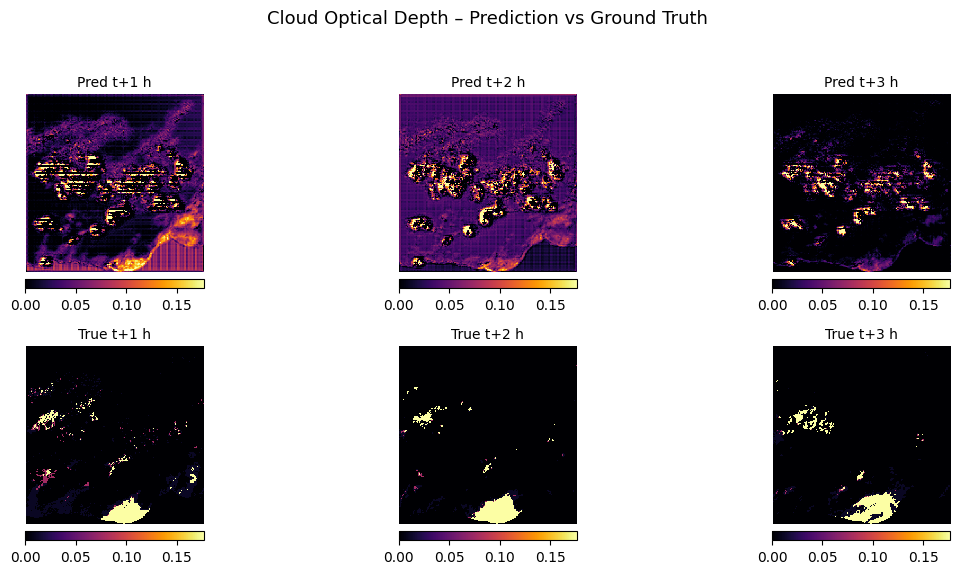

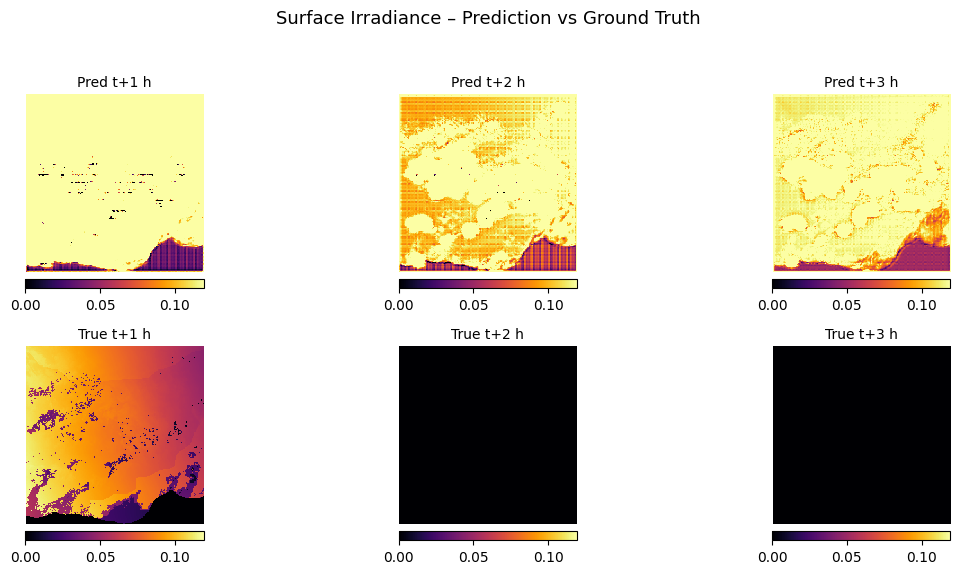

In [82]:
# --- Evaluation mode ---
model.eval()

# --- Select a test sample ---
t = Petdt(datetime.datetime(2021, 6, 8, 6, 0))
inputs, outputs = satpipe[t]  # (7, 2, 276, 276), (3, 2, 276, 276)

# --- Convert to tensors in correct shape (B, C, T, H, W) ---
x = torch.from_numpy(inputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)       # (1, 2, 7, 276, 276)
y_true = torch.from_numpy(outputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device) # (1, 2, 3, 276, 276)

# --- Replace NaN / Inf with 0 ---
x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
y_true = torch.nan_to_num(y_true, nan=0.0, posinf=0.0, neginf=0.0)

# --- Forward pass ---
with torch.no_grad():
    y_pred = model(x)          # (1, 2, 3, 276, 276)
    y_pred = y_pred.squeeze(0).cpu().numpy()
    y_true = y_true.squeeze(0).cpu().numpy()

print("Prediction shape:", y_pred.shape)
print("Ground truth shape:", y_true.shape)

# --- Plot (no rescaling) ---
n_channels, n_pred_times = y_pred.shape[:2]
n_true_times = y_true.shape[1]
n_times = min(n_pred_times, n_true_times)
forecast_hours = [1, 2, 3][:n_times]
var_names = ["Cloud Optical Depth", "Surface Irradiance"]

for ch in range(n_channels):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"{var_names[ch]} – Prediction vs Ground Truth", fontsize=13)

    # consistent colour scale across all timesteps
    vmin = np.nanmin(y_true[ch])
    vmax = np.nanmax(y_true[ch])

    for t_idx in range(n_times):
        # --- Prediction ---
        plt.subplot(2, n_times, t_idx + 1)
        im_pred = plt.imshow(
            y_pred[ch, t_idx],
            cmap="inferno",
            interpolation="none",
            vmin=vmin,
            vmax=vmax
        )
        plt.title(f"Pred t+{forecast_hours[t_idx]} h", fontsize=10)
        plt.axis("off")
        plt.colorbar(im_pred, fraction=0.046, pad=0.04, orientation="horizontal")

        # --- Ground truth ---
        plt.subplot(2, n_times, n_times + t_idx + 1)
        im_true = plt.imshow(
            y_true[ch, t_idx],
            cmap="inferno",
            interpolation="none",
            vmin=vmin,
            vmax=vmax
        )
        plt.title(f"True t+{forecast_hours[t_idx]} h", fontsize=10)
        plt.axis("off")
        plt.colorbar(im_true, fraction=0.046, pad=0.04, orientation="horizontal")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.savefig(f"nowcast_{var_names[ch].replace(' ', '_').lower()}.png", dpi=200)
    plt.show()

# Test data pipeline

In [84]:
testpipe = petpipe.Pipeline(
    himawari,
    petpipe.operations.xarray.Sort(order=["time", "latitude", "longitude"]),
    petpipe.operations.xarray.AlignDataVariableDimensionsToDatasetCoords(),

    petpipe.modifications.TemporalRetrieval(
        concat=True,
        samples=((0, 7, 10), (60, 3, 60)),   # past 7 frames, next 3 forecast frames
        merge_function=proper_temporal_merge,
        delta_unit="minute"
    ),

    # --- Same spatial region: Darwin ---
    petdata.transform.region.Bounding(-15.5, -8, 130, 135.5),

    # --- Apply same per-channel scaling ---
    PerChannelScale(scales),

    # --- Convert to NumPy and rearrange dimensions ---
    petpipe.operations.xarray.conversion.ToNumpy(),
    petpipe.operations.numpy.reshape.Rearrange("t c h w -> c t h w"),

    # --- Test period ---
    iterator=petpipe.iterators.DateRange(
        "20210611T0000",  # start after training range
        "20210612T2300",  # shorter test window for evaluation
        interval="10 minutes"
    ),

    # --- Skip missing or invalid data gracefully ---
    exceptions_to_ignore=(petdata.exceptions.DataNotFoundError, ValueError)
)

Prediction shape: (2, 3, 276, 276)
Ground truth shape: (2, 3, 276, 276)


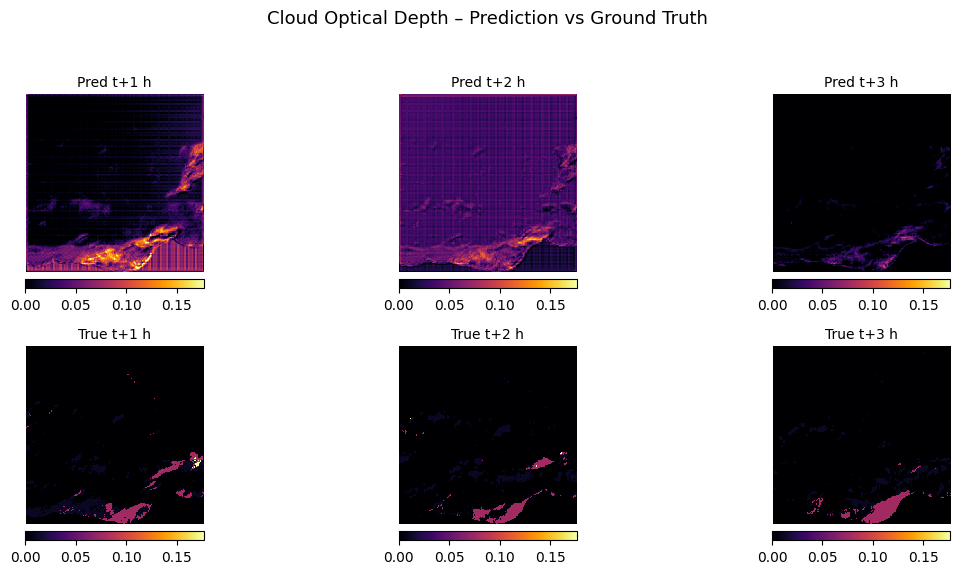

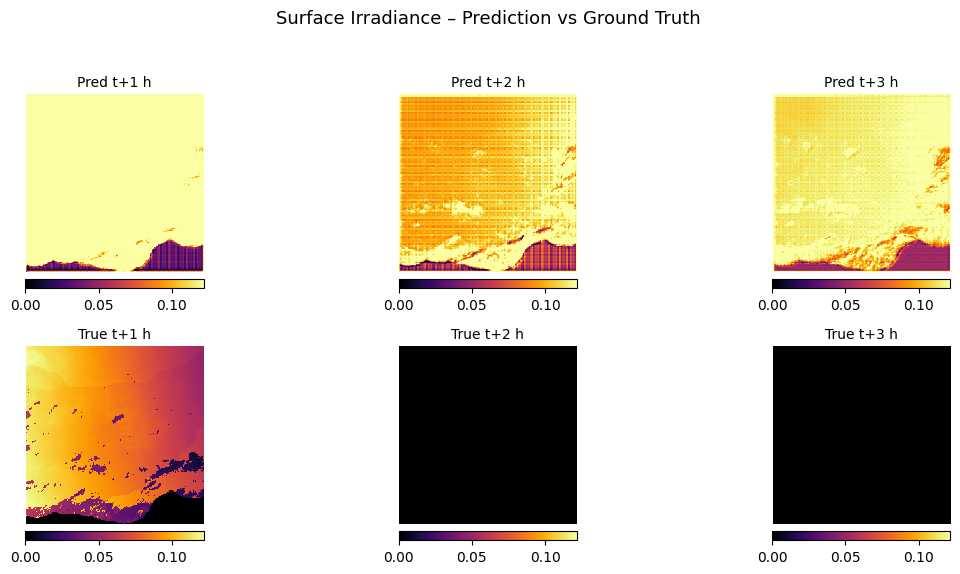

In [86]:
# --- Evaluation mode ---
model.eval()

# --- Select a test sample ---
t = Petdt(datetime.datetime(2021, 6, 11, 6, 0))
inputs, outputs = testpipe[t]  # (7, 2, 276, 276), (3, 2, 276, 276)

# --- Convert to tensors in correct shape (B, C, T, H, W) ---
x = torch.from_numpy(inputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device)       # (1, 2, 7, 276, 276)
y_true = torch.from_numpy(outputs).permute(1, 0, 2, 3).unsqueeze(0).float().to(device) # (1, 2, 3, 276, 276)

# --- Replace NaN / Inf with 0 ---
x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
y_true = torch.nan_to_num(y_true, nan=0.0, posinf=0.0, neginf=0.0)

# --- Forward pass ---
with torch.no_grad():
    y_pred = model(x)          # (1, 2, 3, 276, 276)
    y_pred = y_pred.squeeze(0).cpu().numpy()
    y_true = y_true.squeeze(0).cpu().numpy()

print("Prediction shape:", y_pred.shape)
print("Ground truth shape:", y_true.shape)

# --- Plot (no rescaling) ---
n_channels, n_pred_times = y_pred.shape[:2]
n_true_times = y_true.shape[1]
n_times = min(n_pred_times, n_true_times)
forecast_hours = [1, 2, 3][:n_times]
var_names = ["Cloud Optical Depth", "Surface Irradiance"]

for ch in range(n_channels):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"{var_names[ch]} – Prediction vs Ground Truth", fontsize=13)

    # consistent colour scale across all timesteps
    vmin = np.nanmin(y_true[ch])
    vmax = np.nanmax(y_true[ch])

    for t_idx in range(n_times):
        # --- Prediction ---
        plt.subplot(2, n_times, t_idx + 1)
        im_pred = plt.imshow(
            y_pred[ch, t_idx],
            cmap="inferno",
            interpolation="none",
            vmin=vmin,
            vmax=vmax
        )
        plt.title(f"Pred t+{forecast_hours[t_idx]} h", fontsize=10)
        plt.axis("off")
        plt.colorbar(im_pred, fraction=0.046, pad=0.04, orientation="horizontal")

        # --- Ground truth ---
        plt.subplot(2, n_times, n_times + t_idx + 1)
        im_true = plt.imshow(
            y_true[ch, t_idx],
            cmap="inferno",
            interpolation="none",
            vmin=vmin,
            vmax=vmax
        )
        plt.title(f"True t+{forecast_hours[t_idx]} h", fontsize=10)
        plt.axis("off")
        plt.colorbar(im_true, fraction=0.046, pad=0.04, orientation="horizontal")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.savefig(f"nowcast_{var_names[ch].replace(' ', '_').lower()}.png", dpi=200)
    plt.show()